In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt 
import seaborn as sns
import os

import tensorflow as tf
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization

from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical



In [2]:
tf.__version__
sklearn.__version__
pd.__version__

'2.0.3'

In [3]:
# path definition
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '0'
train_path = "./input/train.csv"
test_path = "./input/test.csv"

# Load Data
train = pd.read_csv(train_path)
test = pd.read_csv(test_path)

In [4]:
print(train.describe())
print(test.describe())

              label   pixel0   pixel1   pixel2   pixel3   pixel4   pixel5  \
count  42000.000000  42000.0  42000.0  42000.0  42000.0  42000.0  42000.0   
mean       4.456643      0.0      0.0      0.0      0.0      0.0      0.0   
std        2.887730      0.0      0.0      0.0      0.0      0.0      0.0   
min        0.000000      0.0      0.0      0.0      0.0      0.0      0.0   
25%        2.000000      0.0      0.0      0.0      0.0      0.0      0.0   
50%        4.000000      0.0      0.0      0.0      0.0      0.0      0.0   
75%        7.000000      0.0      0.0      0.0      0.0      0.0      0.0   
max        9.000000      0.0      0.0      0.0      0.0      0.0      0.0   

        pixel6   pixel7   pixel8  ...      pixel774      pixel775  \
count  42000.0  42000.0  42000.0  ...  42000.000000  42000.000000   
mean       0.0      0.0      0.0  ...      0.219286      0.117095   
std        0.0      0.0      0.0  ...      6.312890      4.633819   
min        0.0      0.0      0

In [5]:
y = train["label"]
x = train.drop(labels = ["label"],axis = 1)

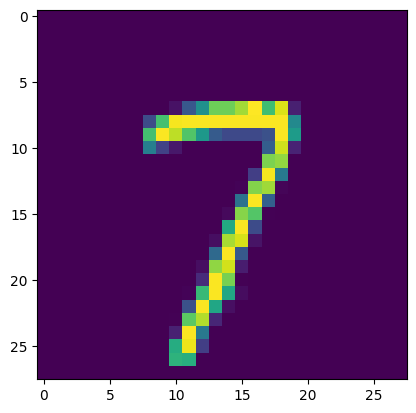

actual number : 7


In [6]:
plt.imshow(x.values[18].reshape(28,28))
plt.show()
print('actual number : {}'.format(y[18]))

In [7]:
#Normalization

x = x/255.0
test = test/255.0

print("x shape ",x.shape)
print("test shape ",test.shape)



x shape  (42000, 784)
test shape  (28000, 784)


In [8]:
# customizing the part

#reshaping
x = x.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)
print(x.shape)
print(test.shape)


#label encoding
y = to_categorical(y, num_classes=10)

y[89]

(42000, 28, 28, 1)
(28000, 28, 28, 1)


array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.], dtype=float32)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(x,y, test_size = 0.1, random_state=45)
print("x_train shape",X_train.shape)
print("y_train shape",y_train.shape)
print("x_test shape",X_test.shape)
print("y_test shape",y_test.shape)

x_train shape (37800, 28, 28, 1)
y_train shape (37800, 10)
x_test shape (4200, 28, 28, 1)
y_test shape (4200, 10)


In [10]:
#adding sequential

model=Sequential()
  
model.add(Conv2D(filters=64, kernel_size = (3,3), activation="relu", input_shape=(28,28,1)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())

model.add(Conv2D(filters=128, kernel_size = (3,3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())    

model.add(Conv2D(filters=256, kernel_size = (3,3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
    
model.add(Flatten())
model.add(Dense(256,activation="relu"))
model.add(Dropout(0.5))

model.add(Dense(512,activation="relu"))
model.add(Dropout(0.5))

#using softmax layer as output layer
model.add(Dense(10,activation="softmax"))

In [11]:
optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999)
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

c:\Users\yoges\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [12]:

#print summary of model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 64)        640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 64)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 13, 13, 64)       256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 128)        0         
 2D)                                                             
                                                        

In [18]:

#generating extra data for incresing accuracy
datagen = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=15,
    zoom_range=0.01,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=False,
    vertical_flip=False)

train_gen = datagen.flow(X_train, y_train, batch_size=64)
test_gen = datagen.flow(X_test, y_test, batch_size=64)

In [19]:
epochs = 100
batch_size = 64
es = tf.keras.callbacks.EarlyStopping(
    monitor="val_acc",
    patience=10,
    verbose=1,
    mode="max",
    restore_best_weights=True,
)

In [20]:
history = model.fit_generator(train_gen, 
                              epochs = epochs, 
                              steps_per_epoch = X_train.shape[0] // batch_size,
                              validation_data = test_gen,
                              validation_steps = X_test.shape[0] // batch_size, 
                              callbacks=es)

Epoch 1/100


C:\Users\yoges\AppData\Local\Temp\ipykernel_18724\864917553.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_gen,


590/590 [==============================] - 25s 42ms/step - loss: 0.1924 - accuracy: 0.9422 - val_loss: 0.1185 - val_accuracy: 0.9625
Epoch 2/100
590/590 [==============================] - 24s 41ms/step - loss: 0.1502 - accuracy: 0.9563 - val_loss: 0.1226 - val_accuracy: 0.9611
Epoch 3/100
590/590 [==============================] - 24s 41ms/step - loss: 0.1361 - accuracy: 0.9618 - val_loss: 0.0906 - val_accuracy: 0.9709
Epoch 4/100
590/590 [==============================] - 26s 43ms/step - loss: 0.1203 - accuracy: 0.9645 - val_loss: 0.0876 - val_accuracy: 0.9709
Epoch 5/100
590/590 [==============================] - 24s 41ms/step - loss: 0.1157 - accuracy: 0.9675 - val_loss: 0.0903 - val_accuracy: 0.9726
Epoch 6/100
590/590 [==============================] - 23s 40ms/step - loss: 0.1115 - accuracy: 0.9670 - val_loss: 0.0921 - val_accuracy: 0.9673
Epoch 7/100
590/590 [==============================] - 23s 39ms/step - loss: 0.1044 - accuracy: 0.9710 - val_loss: 0.0830 - val_accuracy: 0.97

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


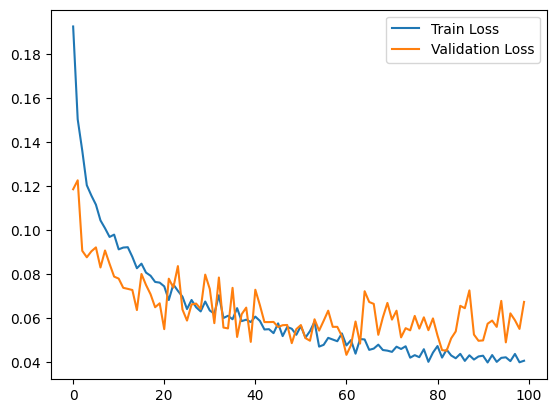

In [25]:
model.save("./output/model.h5")
print(history.history.keys())
plt.plot(history.history["loss"],label="Train Loss")
plt.plot(history.history["val_loss"],label="Validation Loss")
plt.legend()
plt.show()

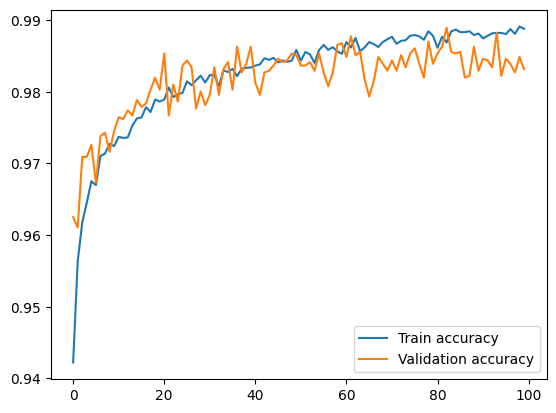

In [26]:
plt.figure()
plt.plot(history.history["accuracy"],label="Train accuracy")
plt.plot(history.history["val_accuracy"],label="Validation accuracy")
plt.legend()
plt.show()

132/132 [==============================] - 1s 6ms/step


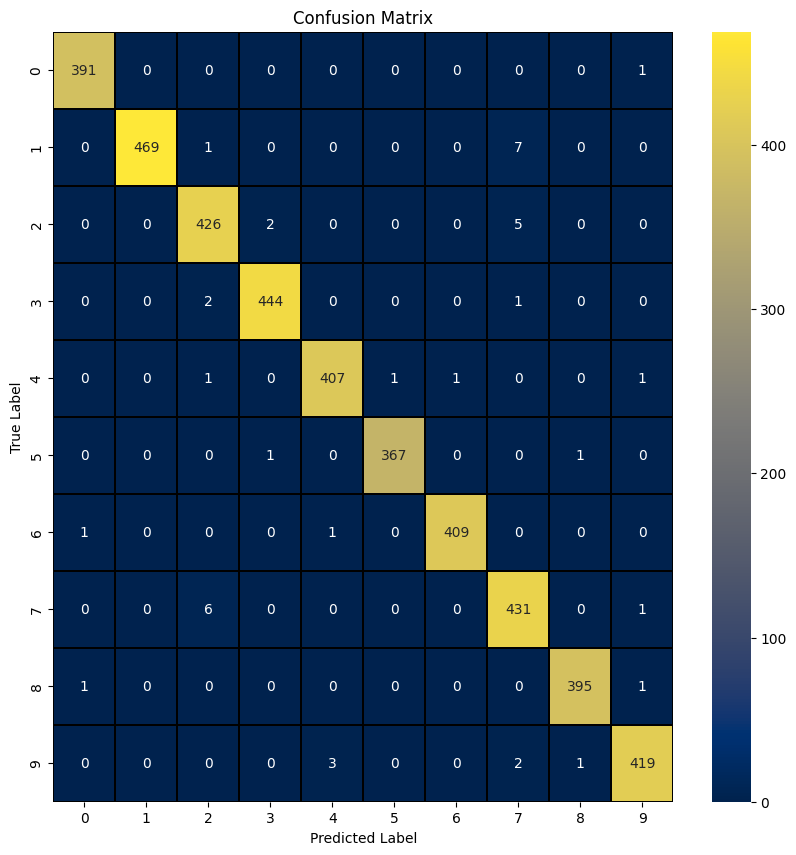

In [27]:
Y_true = np.argmax(y_test, axis=1)

Y_pred = model.predict(X_test)
Y_pred_classes = np.argmax(Y_pred, axis=1)

confusionMatrix = confusion_matrix(Y_true, Y_pred_classes)

f, ax = plt.subplots(figsize=(10, 10))

sns.heatmap(confusionMatrix, annot=True, linewidths=0.1, cmap="cividis", linecolor="black", fmt='.0f', ax=ax)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

132/132 [==============================] - 1s 6ms/step


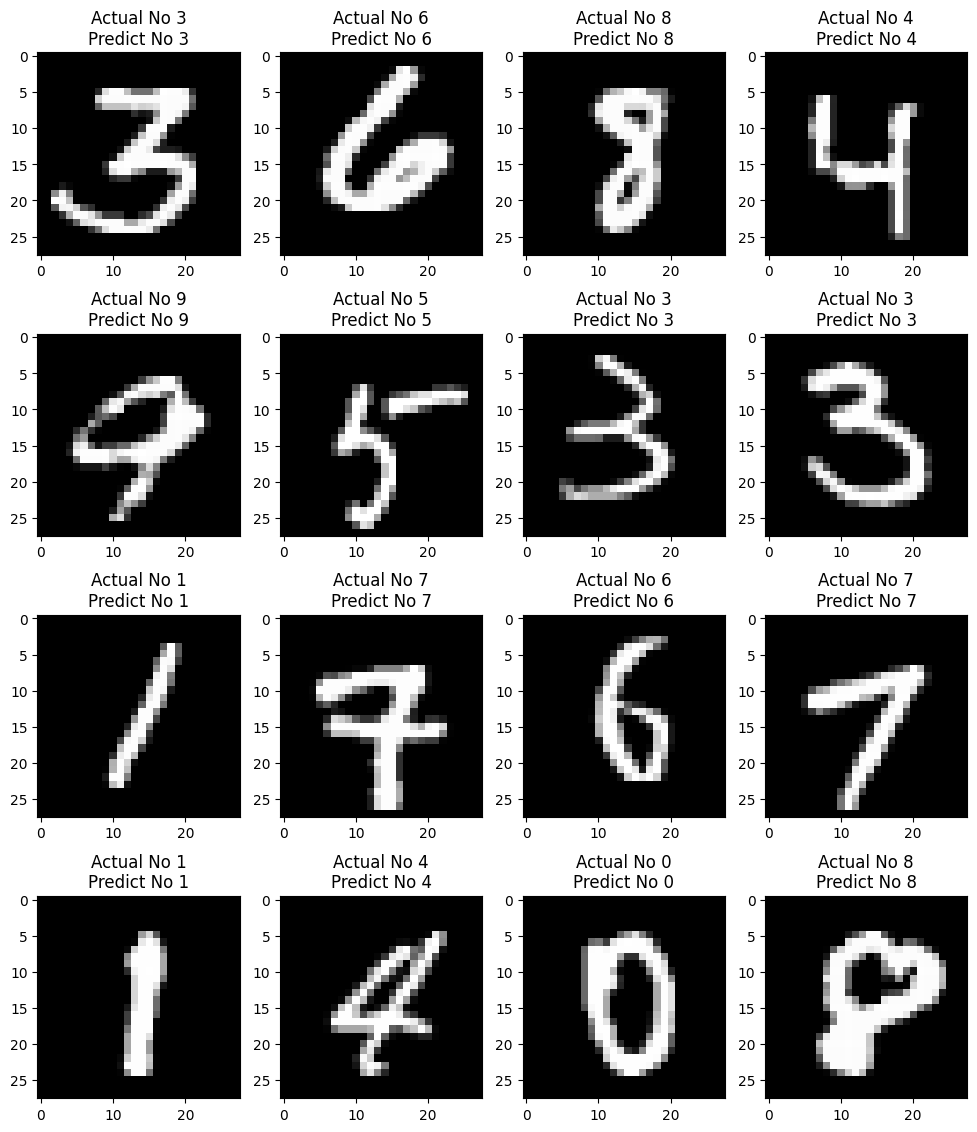

In [28]:
y_pred = model.predict(X_test)
X_test__ = X_test.reshape(X_test.shape[0], 28, 28)

fig, axis = plt.subplots(4, 4, figsize=(12, 14))
for i, ax in enumerate(axis.flat):
    ax.imshow(X_test__[i], cmap='gray')
    ax.set(title = f"Actual No {y_test[i].argmax()}\nPredict No {y_pred[i].argmax()}");